In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

%matplotlib inline

In [2]:
def diff(x,y):
    return np.abs( np.mod( x - y + 90, 180) - 90 )

def G(x,y,sigma):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def G2D(x_range, y_range, mean, sigma):
    x0 = mean[0]
    y0 = mean[1]
    return np.exp( -1*( ( x_range-x0)**2 + (y_range-y0)**2) / (2*sigma**2) )

def mean_connections(W_ab):
    total = 0.
    for i in range(W_ab.shape[0]):
        sub_mat = W_ab[i,:,:]
        total = total + sub_mat[sub_mat != 0].size
    return total / W_ab.shape[0]

def stimulus_size(x,length,sig_RF):
    return (1.+np.exp(-(x + length/2.)/sig_RF) )**-1. * (1. - (1.+np.exp(-(x - length/2.)/sig_RF))**-1. )

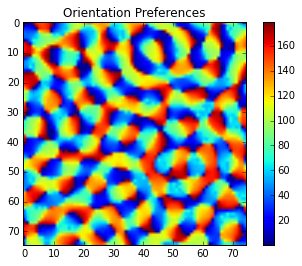

In [3]:
# Determine the connection probabilities 

N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

xy_range = np.linspace(0, field_size, N_pairs, False)
# xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# load from Bryan's code
data = scipy.io.loadmat('orientation-map.mat')
OP_map = data['map']
plt.imshow(OP_map)
plt.colorbar()
plt.title('Orientation Preferences')

# Connection weight parameters (from supp. materials S1.1.2):
kappa_E = 0.1
kappa_I = 0.5
J_EE = 0.1
J_IE = 0.38
J_EI = 0.089
J_II = 0.096

sig_EE = 8*dx
sig_IE = 12*dx
sig_EI = 4*dx
sig_II = 4*dx
sig_ori = 45

# calculate probability of no connections for each neuron (sparse connectivity)

G_EE = np.zeros((N_pairs**2, N_pairs, N_pairs))
G_IE = np.copy(G_EE)

# may not need these
G_EI = np.copy(G_EE)
G_II = np.copy(G_EE)

G_ori = np.copy(G_EE)

pW_EE = np.copy(G_EE)
pW_IE = np.copy(G_EE)
pW_EI = np.copy(G_EE)
pW_II = np.copy(G_EE)

rnd_EE = np.copy(G_EE)
rnd_IE = np.copy(G_EE)
rnd_EI = np.copy(G_EE)
rnd_II = np.copy(G_EE)
np.random.seed(1)

# iterate through each E/I pair:
for i in range(N_pairs):
    for j in range(N_pairs):
        G_EE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EE)
        G_IE[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_IE)
        G_EI[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_EI)
        G_II[N_pairs*i+j, :, :] = G2D( xv, yv, (xv[0,i] , yv[j,0]), sig_II)
        
        G_ori[N_pairs*i+j,:,:] = G(OP_map[j,i], OP_map, sig_ori)
        rnd_EE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_IE[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_EI[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)
        rnd_II[N_pairs*i+j, :, :] = np.random.rand(N_pairs, N_pairs)

for i in range(N_pairs**2):
    pW_EE[i,:,:] = kappa_E * np.multiply(G_EE[i,:,:], G_ori[i,:,:])
    pW_IE[i,:,:] = kappa_E * np.multiply(G_IE[i,:,:], G_ori[i,:,:])
    pW_EI[i,:,:] = kappa_I * np.multiply(G_EI[i,:,:], G_ori[i,:,:])
    pW_II[i,:,:] = kappa_I * np.multiply(G_II[i,:,:], G_ori[i,:,:])
    
# find zero-weighted connections:
W_EE = np.ones((N_pairs**2, N_pairs, N_pairs))
W_IE = np.copy(W_EE)
W_EI = np.copy(W_EE)
W_II = np.copy(W_EE)

W_EE[pW_EE<rnd_EE] = 0
W_IE[pW_IE<rnd_IE] = 0
W_EI[pW_EI<rnd_EI] = 0
W_II[pW_II<rnd_II] = 0

u_EE = mean_connections(W_EE)
u_IE = mean_connections(W_IE)
u_EI = mean_connections(W_EI)
u_II = mean_connections(W_II)

In [4]:
# Print mean number of connections:
print u_EE, u_IE, u_EI, u_II

20.1328 41.1607111111 28.2376888889 28.1884444444


In [5]:
# For non-zero connections, determine the weight 
W_EE[W_EE != 0] = np.random.normal(J_EE, 0.25*J_EE, W_EE[W_EE!=0].size)
W_IE[W_IE != 0] = np.random.normal(J_IE, 0.25*J_IE, W_IE[W_IE!=0].size)
W_EI[W_EI != 0] = np.random.normal(J_EI, 0.25*J_EI, W_EI[W_EI!=0].size)
W_II[W_II != 0] = np.random.normal(J_II, 0.25*J_II, W_II[W_II!=0].size)

# W_EE[W_EE != 0] = np.random.normal(J_EE, (0.25*J_EE)**2, W_EE[W_EE!=0].size)
# W_IE[W_IE != 0] = np.random.normal(J_IE, (0.25*J_IE)**2, W_IE[W_IE!=0].size)
# W_EI[W_EI != 0] = np.random.normal(J_EI, (0.25*J_EI)**2, W_EI[W_EI!=0].size)
# W_II[W_II != 0] = np.random.normal(J_II, (0.25*J_II)**2, W_II[W_II!=0].size)

# Set negative weights to zero:
W_EE[W_EE < 0] = 0
W_IE[W_IE < 0] = 0
W_EI[W_EI < 0] = 0
W_II[W_II < 0] = 0

# W_EE = W_EE*1.15

# "Weights of a given type 'b' onto each unit 
# are then scaled so that all units of a given type 'a' receive the same 
# total type b synaptic weight, equal to Jab times the mean number of 
# connections received under p (Wab(x, x′) ̸= 0)"
for i in range(N_pairs**2):
    if np.all(W_EE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EE[i,:,:] = W_EE[i,:,:]*J_EE*u_EE/np.sum(W_EE[i,:,:])
    
    if np.all(W_IE[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_IE[i,:,:] = W_IE[i,:,:]*J_IE*u_IE/np.sum(W_IE[i,:,:])

    if np.all(W_EI[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_EI[i,:,:] = W_EI[i,:,:]*J_EI*u_EI/np.sum(W_EI[i,:,:])

    if np.all(W_II[i,:,:] == np.zeros((N_pairs, N_pairs))) == False:
        W_II[i,:,:] = W_II[i,:,:]*J_II*u_II/np.sum(W_II[i,:,:])

In [6]:
# From S.1.3.2: for strongest nonlinear behaviour, omega_E < 0 and omega_E < omega_I
# where omega_E = sum(W_II) - sum(W_EI), omega_I = sum(W_IE) - sum(W_EE)
# Verify here:

omega_E = np.sum(W_II) - np.sum(W_EI)
omega_I = np.sum(W_IE) - np.sum(W_EE)

print 'Omega_E: ', omega_E
print 'Omega_I: ', omega_I

if omega_E < 0 and omega_I > omega_E:
    print "System should show strong nonlinear behaviour!"
else:
    print "System may not show strong nonlinear behaviour."

Omega_E:  1085.267
Omega_I:  76656.32
System may not show strong nonlinear behaviour.


In [7]:
# Model parameters (from supplementary methods)

k   = np.random.normal(0.012, 0.05*0.012, (N_pairs, N_pairs))
n_E = np.random.normal(2.0, 0.05*2.0, (N_pairs, N_pairs)) 
n_I = np.random.normal(2.2, 0.05*2.2, (N_pairs, N_pairs))
sig_FF = 32
sig_RF = dx

tau_E = np.random.normal(0.02, 0.05*0.02, (N_pairs, N_pairs))
tau_I = np.random.normal(0.01, 0.05*0.01, (N_pairs, N_pairs))

In [8]:
def generate_ext_stimulus(ori, size, centre, full_frame=False):
    G_FF = G(ori, OP_map, sig_FF)
    
    if full_frame==True:
        h = G_FF
    else:
        x_distance = np.abs(xv - centre[0])
        y_distance = np.abs(yv - centre[1])
        dist = np.sqrt(x_distance**2 + y_distance**2)
        s_l = stimulus_size(dist, size, sig_RF)
        h = np.multiply( s_l, G_FF )
        
    return h

In [9]:
def run_simulation( dt, timesteps, c, h, init_cond=[np.zeros((N_pairs, N_pairs)),np.zeros((N_pairs, N_pairs))]):
    r_E = np.zeros((timesteps, N_pairs, N_pairs))
    r_I = np.copy(r_E)

    # add initial conditions:
    r_E[0,:,:] = init_cond[0]
    r_I[0,:,:] = init_cond[1]

    I_E = np.zeros((timesteps, N_pairs, N_pairs))
    I_I = np.copy(I_E)
    # rSS_E = np.copy(I_E)
    # rSS_I = np.copy(I_I)

    for t in range(1,timesteps):
        # Input drive from external input and network
#         I_E[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_EE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T - np.sum( np.reshape(np.multiply(W_EI, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T
#         I_I[t,:,:] = c*h + np.sum( np.reshape(np.multiply(W_IE, r_E[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T - np.sum( np.reshape(np.multiply(W_II, r_I[t-1,:,:]), (N_pairs, N_pairs, N_pairs**2)), 2).T

        I_E[t,:,:] = c*h + np.sum( np.sum( W_EE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_EI * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T 
        I_I[t,:,:] = c*h + np.sum( np.sum( W_IE * r_E[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T - np.sum( np.sum( W_II * r_I[t-1,:,:],1 ), 1 ).reshape(N_pairs, N_pairs).T 
        
        # steady state firing rates - power law I/O
        rSS_E = np.multiply(k, np.power(np.fmax(0,I_E[t,:,:]), n_E))
        rSS_I = np.multiply(k, np.power(np.fmax(0,I_I[t,:,:]), n_I))

        # set negative steady state rates to zero
        rSS_E[rSS_E < 0] = 0
        rSS_I[rSS_I < 0] = 0

        # instantaneous firing rates approaching steady state
        r_E[t,:,:] = r_E[t-1,:,:] + dt*(np.divide(-r_E[t-1,:,:]+rSS_E, tau_E))
        r_I[t,:,:] = r_I[t-1,:,:] + dt*(np.divide(-r_I[t-1,:,:]+rSS_I, tau_I))
        
    return [r_E, r_I, I_E, I_I]

In [22]:
# run a single simulation for testing 

r_units = np.floor(N_pairs*np.random.rand(5,2))

h = generate_ext_stimulus(45, 8, (8,8))
dt = 0.005
timesteps = 100
c = 40
[r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h)

# plt.figure()
# plt.hold(True)
# for i in range(len(r_units)):
#     plt.plot(np.linspace(0,dt*timesteps,timesteps), r_E[:,r_units[i,0],r_units[i,1]],'r')
# plt.title('Individual Excitatory Response')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Firing Rate (Hz)')

plt.figure()
plt.imshow(r_E[-1,:,:])
plt.colorbar()

KeyboardInterrupt: 

Average E rate:  0.991671538051
Average I rate:  9.78639809389
Maximum E Rate:  38.9352825187
Maximum I Rate:  469.409349815
1284


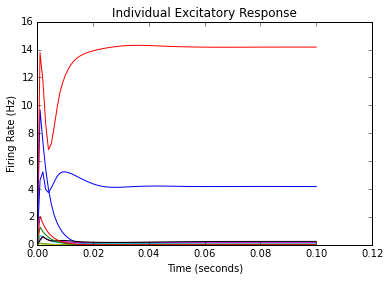

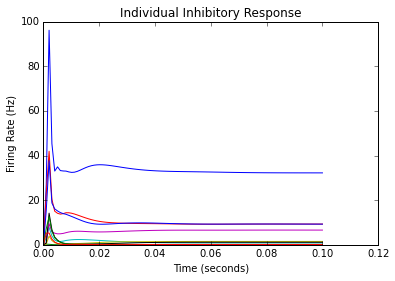

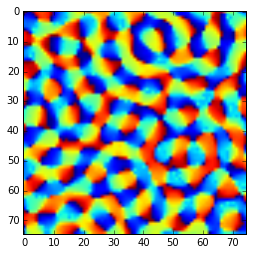

In [64]:
# Plot results of single stimulus trial 

plt.figure()
plt.hold(True)
rnd_units = np.floor( 75*np.random.rand( 10, 2 ) )
for i in range(10):
    plt.plot(np.linspace(0,0.1,100), r_E[:,rnd_units[i,0],rnd_units[i,1]])
plt.title('Individual Excitatory Response')
plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')

print "Average E rate: ", np.mean(r_E)
print "Average I rate: ", np.mean(r_I)
print 'Maximum E Rate: ', np.max(r_E)
print 'Maximum I Rate: ', np.max(r_I)

plt.figure()
plt.hold(True)
for i in range(10):
    plt.plot(np.linspace(0,0.1,100), r_I[:,rnd_units[i,0],rnd_units[i,1]])
plt.title('Individual Inhibitory Response')
plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')

plt.figure()
plt.imshow(OP_map)

print r_E[-1,:,:][np.floor(r_E[-1,:,:]) != 0].size

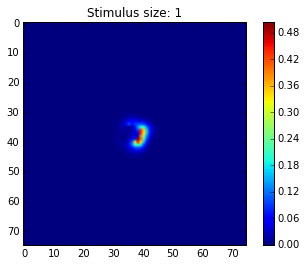

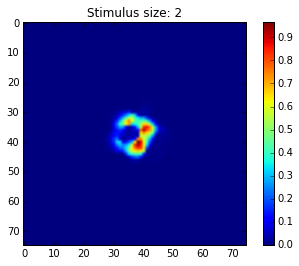

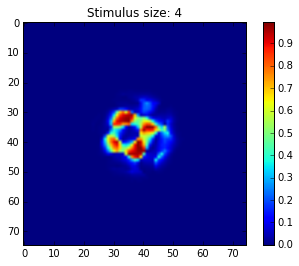

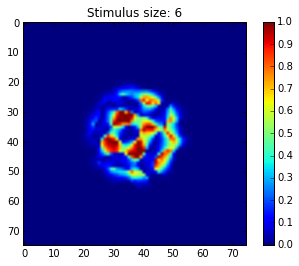

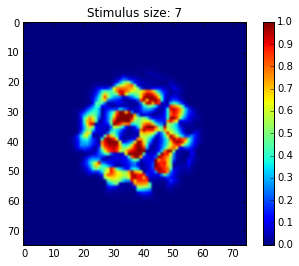

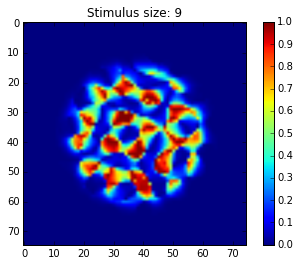

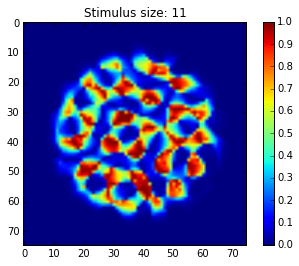

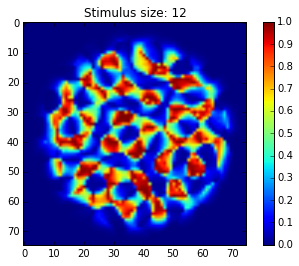

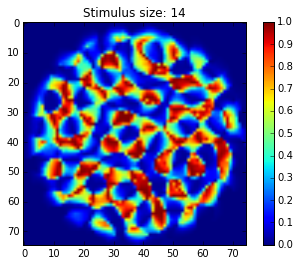

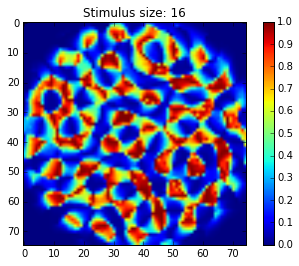

In [65]:
# parameters for simulation to reproduce mean length tuning curves, figure 6E
size_range = np.linspace(1,16,10) # size
c = 40
stim_ori = 45 # degrees
centre = (8,8)
h_range = np.zeros((len(size_range), N_pairs, N_pairs))

for i in range(len(size_range)):
    h_range[i,:,:] = generate_ext_stimulus(stim_ori, size_range[i], centre)
    plt.figure()
    plt.imshow(h_range[i,:,:])
    plt.title('Stimulus size: %d' % size_range[i])
    plt.colorbar()

dt = 0.005
timesteps = 100


In [27]:
# run simulations to reproduce mean length tuning curves, figure 6E
# (this will take a long time to run)
# store all the firing rates for every trial
results_E = np.zeros((len(size_range), timesteps, N_pairs, N_pairs))
results_I = np.copy(results_E)
results_I_E = np.copy(results_E)
results_I_I = np.copy(results_E)

for i in range(len(size_range)):
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h_range[i])
                   
    results_E[i,:,:,:] = r_E
    results_I[i,:,:,:] = r_I
    results_I_E[i,:,:,:] = I_E
    results_I_I[i,:,:,:] = I_I

/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: overflow encountered in power
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: overflow encountered in multiply
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: overflow encountered in power
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:24: RuntimeWarning: overflow encountered in multiply
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: overflow encountered in divide
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: overflow encountered in divide
/Users/mollybeckel/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: RuntimeWarning: invalid value encountered in multiply
/Users/mollybeckel/anaconda/lib/python2.7/site-packag

Number of E units showing strong surround suppression:  1447
Number of I units showing strong surround suppression:  1766


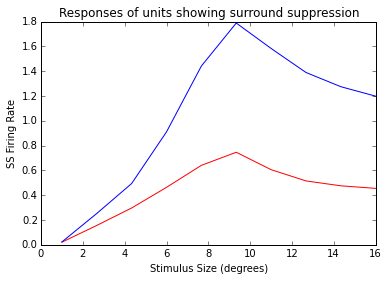

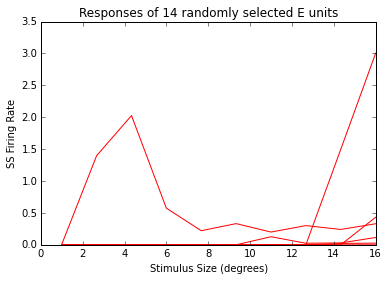

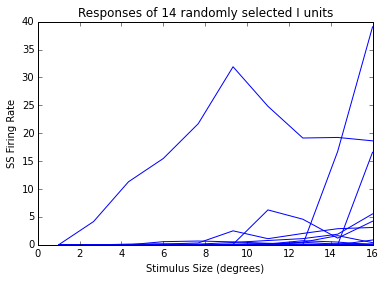

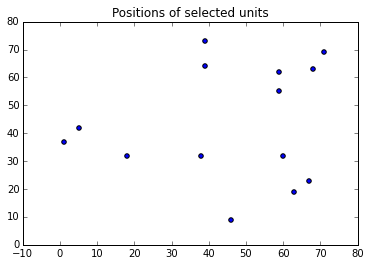

In [67]:
# Find which units demonstrate SSI > 0.25:
# first, find max firing rates for stimuli shorter than 2/3 * 16 degrees:
trials = size_range[ size_range < 2./3*field_size ].size 

# r_max - maximum firing rate to stimuli shorter tha (2/3)*16 degrees
# r_max_E = np.max( np.max( results_E[:trials, :, :, :], 1), 0 )
r_max_E = np.max( results_E[:trials, -1, :, :], 0)

# r_full - response to the largest stimulus
r_full_E = results_E[-1, -1, :, :]

SSI_E = (r_max_E - r_full_E) / r_max_E

print 'Number of E units showing strong surround suppression: ', SSI_E[SSI_E > 0.25].size

# r_max_I = np.max( np.max( results_I[:trials, :, :, :], 1), 0 )
r_max_I = np.max( results_I[:trials, -1, :, :], 0)
r_full_I = results_I[-1, -1, :, :]

SSI_I = (r_max_I - r_full_I) / r_max_I

print 'Number of I units showing strong surround suppression: ',  SSI_I[SSI_I > 0.25].size

y_I, x_I = np.where(SSI_I > 0.25)
y_E, x_E = np.where(SSI_E > 0.25)

avg_r_E = np.zeros(len(size_range))
avg_r_I = np.copy(avg_r_E)
max_r_E = np.copy(avg_r_E)
max_r_I = np.copy(avg_r_E)
SS_r_E  = np.copy(avg_r_E)
SS_r_I  = np.copy(avg_r_E)

for i in range(len(size_range)):
    avg_r_E[i] = np.mean( results_E[i, :, y_E, x_E] )
    avg_r_I[i] = np.mean( results_I[i, :, y_I, x_I] )
    
    max_r_E[i] = np.mean(np.max( results_E[i, :, y_E, x_E], 0 ))
    max_r_I[i] = np.mean(np.max( results_I[i, :, y_I, x_I], 0 ))
    
    SS_r_E[i] = np.mean( results_E[i, -1, y_E, x_E] )
    SS_r_I[i] = np.mean( results_I[i, -1, y_I, x_I] )
    
# plt.figure()
# plt.plot(size_range, avg_r_E, 'r', size_range, avg_r_I, 'b')
# plt.ylabel('Average Firing Rate')
# plt.xlabel('Stimulus Size (degrees)')

# plt.figure()
# plt.plot(size_range, max_r_E, 'r', size_range, max_r_I, 'b')
# plt.ylabel('Max Firing Rate')
# plt.xlabel('Stimulus Size (degrees)')

plt.figure()
plt.plot(size_range, SS_r_E, 'r', size_range, SS_r_I, 'b')
plt.ylabel('SS Firing Rate')
plt.xlabel('Stimulus Size (degrees)')
plt.title('Responses of units showing surround suppression')

r_units = np.floor(N_pairs*np.random.rand(14,2))

plt.figure()
plt.hold(True)
for i in range(len(r_units)):
    plt.plot(size_range, results_E[:, -1, r_units[i,0], r_units[i,1]], 'r')
plt.ylabel('SS Firing Rate')
plt.xlabel('Stimulus Size (degrees)')
plt.title('Responses of %d randomly selected E units' % len(r_units))
                             
plt.figure()
plt.hold(True)
for i in range(len(r_units)):
    plt.plot(size_range, results_I[:, -1, r_units[i,0], r_units[i,1]], 'b')
plt.ylabel('SS Firing Rate')
plt.xlabel('Stimulus Size (degrees)')
plt.title('Responses of %d randomly selected I units' % len(r_units))

plt.figure()
plt.title('Positions of selected units')
plt.scatter(r_units[:,1], r_units[:,0])


4.12270255628e-21
2.74462053179e-21
6.18275072282e-22
1.14866372072e-22
8.98134876914e-26
0.00674829142958
8.64591955326e-20
1.40347264537e-19
0.844327759179
9.7820873336e-20
8.74200494429e-32
1.6024839592e-19
3.3583248626
3.06855284698e-25


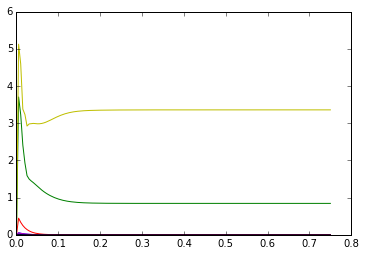

In [20]:
for i in range(len(r_units)):
    print results_E[6,-1,r_units[i,0], r_units[i,1]]
    
plt.figure()
for i in range(len(r_units)):
    plt.plot( np.linspace(0,dt*timesteps, timesteps), results_E[6,:,r_units[i,0], r_units[i,1]])

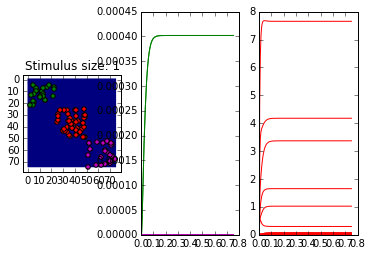

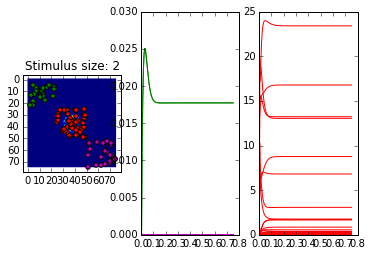

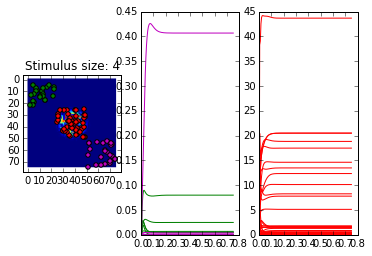

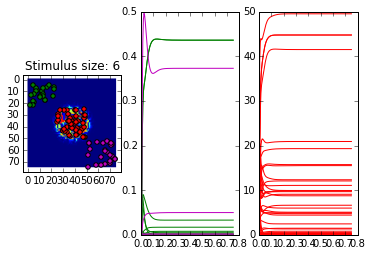

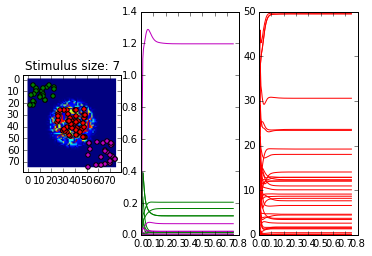

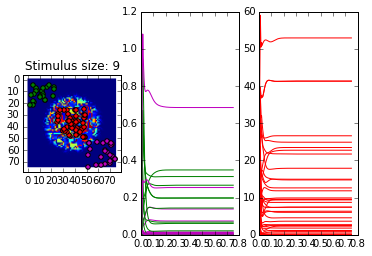

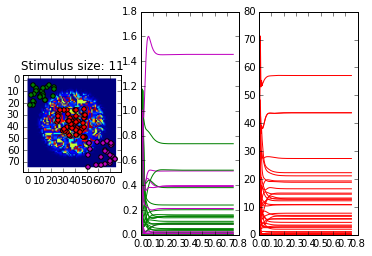

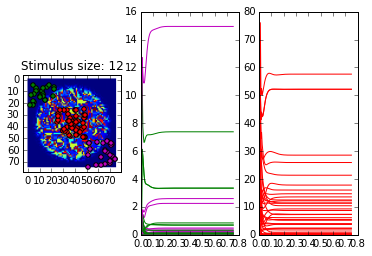

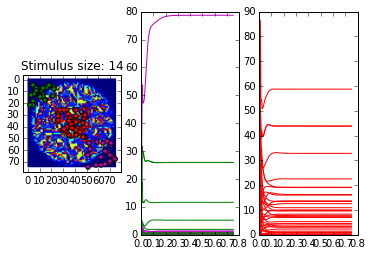

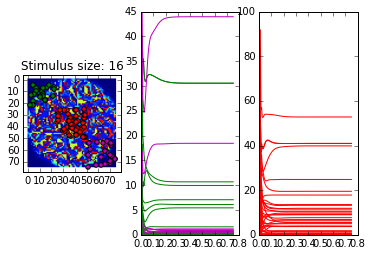

In [61]:
o_units = np.floor( 25* np.random.rand(25,2) )
o2_units = np.floor( 25* np.random.rand(25,2) + 50 )
i_units = np.floor( 25*np.random.rand(50,2) + 25 )

for i in range(len(size_range)):
#     plt.figure()
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(h_range[i,:,:])
#     plt.colorbar()
    ax[0].scatter(o_units[:,1], o_units[:,0], c='g')
    ax[0].scatter(o2_units[:,1], o2_units[:,0], c='m')
    ax[0].scatter(i_units[:,1], i_units[:,0], c='r')
    ax[0].set_title('Stimulus size: %d' % size_range[i])
    
    for j in range(25):
        ax[1].plot(np.linspace(0, dt*timesteps, timesteps), results_I[i, :, o_units[j,0], o_units[j,1]], 'g')
        ax[1].plot(np.linspace(0, dt*timesteps, timesteps), results_I[i, :, o2_units[j,0], o2_units[j,1]], 'm')
        
    for j in range(50):
        ax[2].plot(np.linspace(0, dt*timesteps, timesteps), results_I[i, :, i_units[j,0], i_units[j,1]], 'r')

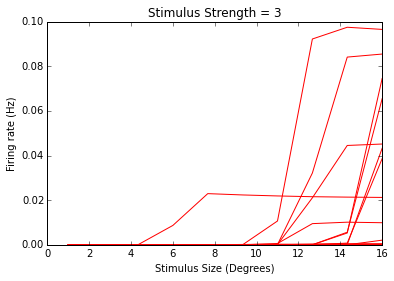

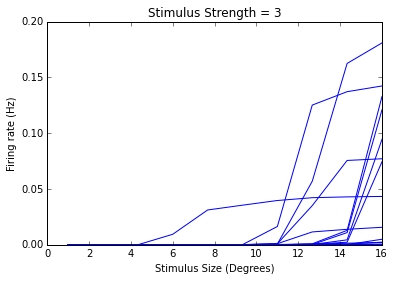

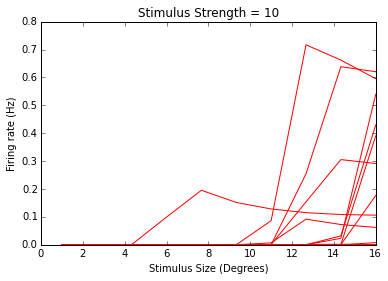

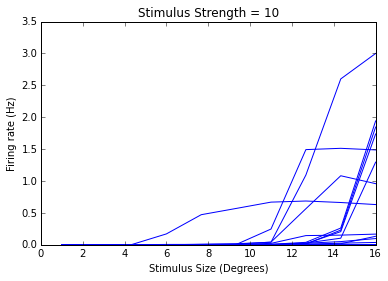

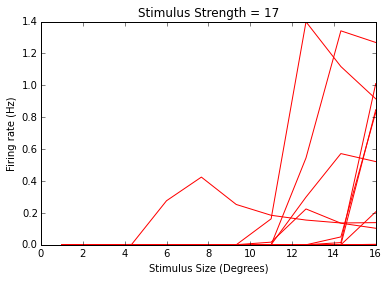

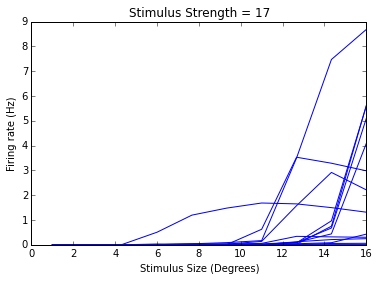

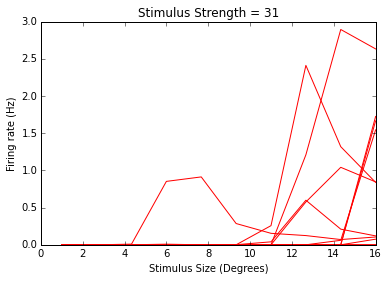

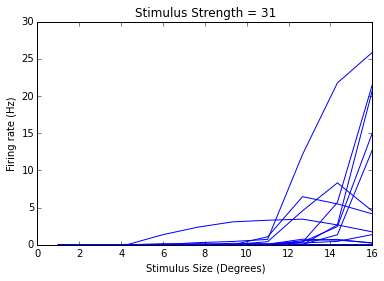

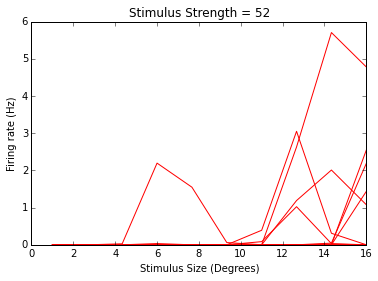

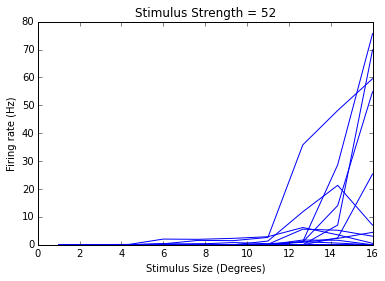

In [25]:
# Reproduction of figure 6F - length tuning for various levels of stimulus strength:

dt = 0.005
timesteps = 100

c_range = np.array([3,10,17,31,52])
# c_range = np.array([3])

# select 14 random units:
n_units = 14
r_units = np.floor( N_pairs*np.random.rand(n_units,2) )

size_range = np.linspace(1,16,10) # size
stim_ori = 45 # degrees
centre = (8,8)
h_range = np.zeros((len(size_range), N_pairs, N_pairs))

for i in range(len(size_range)):
    h_range[i,:,:] = generate_ext_stimulus(stim_ori, size_range[i], centre)

# store all the firing rates for every trial
results_E = np.zeros((len(c_range), len(size_range), timesteps, N_pairs, N_pairs))
results_I = np.copy(results_E)
    
for i in range(len(c_range)):
    c = c_range[i]
    
    SS_r_E = np.zeros((len(size_range), N_pairs, N_pairs))
    SS_r_I = np.copy(SS_r_E)

    for j in range(len(size_range)):
        [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c, h_range[j])

        results_E[i,j,:,:,:] = r_E
        results_I[i,j,:,:,:] = r_I
        
        SS_r_E[j,:,:] = r_E[-1,:,:]
        SS_r_I[j,:,:] = r_I[-1,:,:]
    
    
    plt.figure()
    plt.hold(True)
    plt.title('Stimulus Strength = %d' % c)
    plt.ylabel('Firing rate (Hz)')
    plt.xlabel('Stimulus Size (Degrees)')
    for r in range(n_units):
        plt.plot(size_range, SS_r_E[:, r_units[r, 0], r_units[r,1]], 'r')
                                     
    plt.figure()
    plt.hold(True)
    plt.title('Stimulus Strength = %d' % c)
    plt.ylabel('Firing rate (Hz)')
    plt.xlabel('Stimulus Size (Degrees)')
    for r in range(n_units):
        plt.plot(size_range, SS_r_I[:, r_units[r, 0], r_units[r,1]], 'b')
        
    

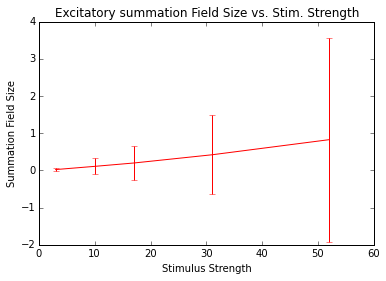

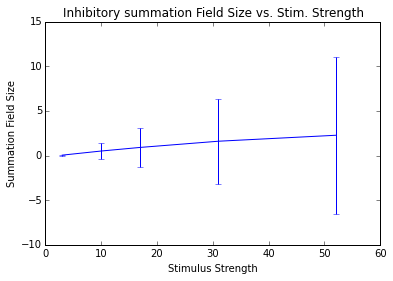

In [26]:
# Reproducing figure 6G - showing summation field size shrinking with 
# increasing stimulus strength

# first, randomly select 100 units
n_units = 100
r_units = np.floor( N_pairs*np.random.rand(n_units,2) )

# get steady-state results from simulation results:
SS_r_E = np.zeros( ( len(c_range), len(h_range), n_units ) )
SS_r_I = np.copy(SS_r_E)

for j in range(len(c_range)):
    for i in range(len(h_range)):
        for k in range(n_units):
            SS_r_E[j,i,k] = results_E[j,i,-1,r_units[k,0], r_units[k,1]]
            SS_r_I[j,i,k] = results_I[j,i,-1,r_units[k,0], r_units[k,1]]

def find_first_peak(data):
    max_val = data[0]
    for i in range(len(data)):
        if data[i] >= max_val:
            max_val = data[i]
        else:
            break
    return max_val

peaks_E = np.zeros( ( len(c_range), n_units ) )
peaks_I = np.copy(peaks_E)

for j in range(len(c_range)):
    for i in range(n_units):
        peaks_E[j, i] = find_first_peak( SS_r_E[j, :, i ] )
        peaks_I[j, i] = find_first_peak( SS_r_I[j, :, i ] )
    
avg_peak_E = np.zeros( len(c_range) )
avg_peak_I = np.copy(avg_peak_E)
sd_peak_E = np.copy(avg_peak_E)
sd_peak_I = np.copy(avg_peak_E)

avg_peak_E = np.mean(peaks_E, 1)
sd_peak_E = np.std(peaks_E, 1)
avg_peak_I = np.mean(peaks_I, 1)
sd_peak_I = np.std(peaks_I, 1)

plt.figure()
plt.errorbar(c_range, avg_peak_E, sd_peak_E, fmt='r')
plt.xlabel('Stimulus Strength')
plt.ylabel('Summation Field Size')
plt.title('Excitatory summation Field Size vs. Stim. Strength')

plt.figure()
plt.errorbar(c_range, avg_peak_I, sd_peak_I)
plt.xlabel('Stimulus Strength')
plt.ylabel('Summation Field Size')
plt.title('Inhibitory summation Field Size vs. Stim. Strength')


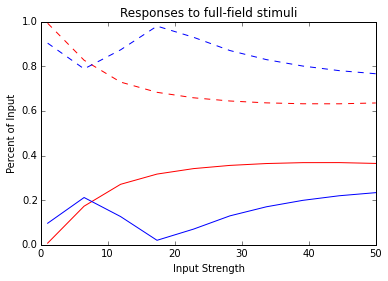

In [10]:
# Recreate figure 6B - showing network transition from externally driven to network-driven
# with increasing stimulus strength

# First, run simulations with full field gratings and several contrast strengths:
c_range = np.linspace(1, 50, 10)
dt = 0.005
timesteps = 100
stim_pref = 45
ff_stim = generate_ext_stimulus(stim_pref, 0, 0, full_frame=True)

results_E = np.zeros((len(c_range), timesteps, N_pairs, N_pairs))
results_I = np.copy(results_E)
results_I_E = np.copy(results_E)
results_I_I = np.copy(results_E)

for i in range(len(c_range)):
    [r_E, r_I, I_E, I_I] = run_simulation(dt, timesteps, c_range[i], ff_stim)
     
    results_E[i,:,:,:] = r_E
    results_I[i,:,:,:] = r_I
    results_I_E[i,:,:,:] = I_E
    results_I_I[i,:,:,:] = I_I                     



f_I_E = np.sum(np.sum(np.abs(results_I_E[:,-1,:,:]), 2), 1)
f_I_I = np.sum(np.sum(np.abs(results_I_I[:,-1,:,:]), 2), 1)

plt.figure()
ext_input = np.zeros(len(c_range))
for i in range(len(c_range)):
    ext_input[i] = np.sum(c_range[i]*ff_stim)
    f_I_E[i] = f_I_E[i] - ext_input[i]
    f_I_I[i] = f_I_I[i] - ext_input[i]

f_I_E = np.abs(f_I_E)
f_I_I = np.abs(f_I_I)
    
plt.plot( c_range, f_I_E/(ext_input+f_I_E), 'r')
plt.plot( c_range, ext_input/(ext_input+f_I_E), 'r--')
plt.plot( c_range, f_I_I/(ext_input+f_I_I), 'b')
plt.plot( c_range, ext_input/(ext_input+f_I_I), 'b--')  
plt.title('Responses to full-field stimuli')
plt.xlabel('Input Strength')
plt.ylabel('Percent of Input')

[ 42.79245283  46.86792453  43.81132075  48.22641509  44.83018868
  44.49056604  47.54716981  40.75471698  42.11320755  47.88679245
  46.86792453  40.75471698  42.79245283  46.86792453  48.90566038
  47.88679245  43.47169811  48.56603774  49.9245283   45.50943396
  46.52830189  45.16981132  44.83018868  48.22641509  40.75471698]
(75, 75)
(75, 75)


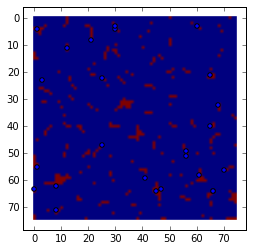

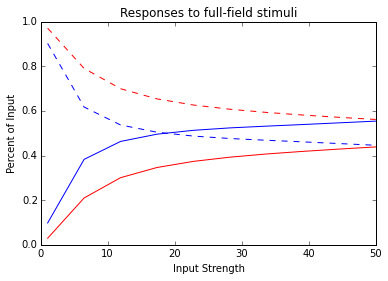

In [49]:
stim_pref = 45
# Find all units with orientation preference within 10 degrees of the stimulus orientation
pref_units = np.where( np.logical_and(OP_map > stim_pref - 5, OP_map < stim_pref + 5) ) 

# randomly select 25 of those units to average over
r_units = np.floor( pref_units[0].size*np.random.rand( 25 ) )
r_units = r_units.astype(int)

unit_idx_x = pref_units[1][r_units]
unit_idx_y = pref_units[0][r_units]
    
# Sanity check for x,y ordering
print OP_map[unit_idx_y, unit_idx_x]
plt.figure()
plt.imshow(np.logical_and(OP_map > stim_pref - 5, OP_map < stim_pref + 5))
plt.scatter(unit_idx_x, unit_idx_y)

net_E = np.zeros((len(c_range), len(r_units)))
net_I = np.copy(net_E)                 

for i in range(len(c_range)):
    for j in range(len(r_units)): 
        net_E[i,j] = np.sum(np.multiply(results_E[i,-1,:,:],W_EE[unit_idx_y[j] + N_pairs*unit_idx_x[j],:,:])) + np.sum(np.multiply(results_I[i,-1,:,:],W_EI[unit_idx_y[j] + N_pairs*unit_idx_x[j],:,:]))
        net_I[i,j] = np.sum(np.multiply(results_E[i,-1,:,:],W_IE[unit_idx_y[j] + N_pairs*unit_idx_x[j],:,:])) + np.sum(np.multiply(results_I[i,-1,:,:],W_II[unit_idx_y[j] + N_pairs*unit_idx_x[j],:,:]))

external_drive = np.tile(ff_stim[unit_idx_y, unit_idx_x], (len(c_range), 1))*c_range[:, np.newaxis]

net_percent_E = net_E / (net_E + external_drive)
net_percent_I = net_I / (net_I + external_drive)

ext_percent_E = external_drive / (net_E + external_drive)
ext_percent_I = external_drive / (net_I + external_drive)

plt.figure()
plt.plot( c_range, np.mean( net_percent_E, 1), 'r')
plt.plot( c_range, np.mean( ext_percent_E, 1), 'r--')
plt.plot( c_range, np.mean( net_percent_I, 1), 'b')
plt.plot( c_range, np.mean( ext_percent_I, 1), 'b--')  
plt.title('Responses to full-field stimuli')
plt.xlabel('Input Strength')
plt.ylabel('Percent of Input')


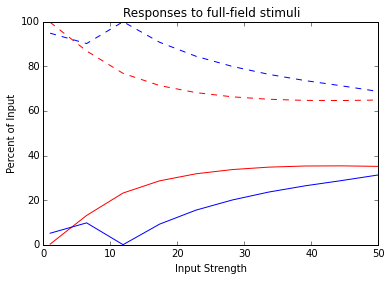

In [60]:
# randomly select 25 units:
r_units = np.floor(N_pairs*np.random.rand(25,2))
rx = r_units[:,0].tolist()
ry = r_units[:,1].tolist()

# f_I_E = np.sum(np.sum(np.abs(results_I_E[:,-1,:,:]), 2), 1)
# f_I_I = np.sum(np.sum(np.abs(results_I_I[:,-1,:,:]), 2), 1)

f_I_E = np.zeros(len(c_range))
f_I_I = np.zeros(len(c_range))
for i in range(len(c_range)):
#     f_I_E[i] = np.mean(np.abs(results_I_E[i,-1,:,:]))
#     f_I_I[i] = np.mean(np.abs(results_I_I[i,-1,:,:]))
    f_I_E[i] = np.abs(results_I_E[i,-1,33,33])
    f_I_I[i] = np.abs(results_I_I[i,-1,33,33])

plt.figure()
ext_input = np.zeros(len(c_range))
for i in range(len(c_range)):
#     ext_input[i] = np.sum(c_range[i]*ff_stim)
#     ext_input[i] = np.mean(c_range[i]*ff_stim)
    ext_input[i] = c_range[i]*ff_stim[33,33]
    f_I_E[i] = f_I_E[i] - ext_input[i]
    f_I_I[i] = f_I_I[i] - ext_input[i]

f_I_E = np.abs(f_I_E)
f_I_I = np.abs(f_I_I)
    
plt.plot( c_range, f_I_E/(ext_input+f_I_E)*100, 'r')
plt.plot( c_range, ext_input/(ext_input+f_I_E)*100, 'r--')
plt.plot( c_range, f_I_I/(ext_input+f_I_I)*100, 'b')
plt.plot( c_range, ext_input/(ext_input+f_I_I)*100, 'b--')  
plt.title('Responses to full-field stimuli')
plt.xlabel('Input Strength')
plt.ylabel('Percent of Input')
plt.savefig('figure6b.png')

0.132936145455
0.433862564103
[ 0.13312768  0.1332781   0.13324754  0.13305094  0.13313868  0.13331727
  0.13374414  0.13241922  0.13292986  0.1338831   0.13320532  0.13099575
  0.13321261  0.13299343  0.13372492  0.13354596  0.13352682  0.13246295
  0.13203388  0.13186648  0.13176214  0.1331284 ]
[ 0.42913081  0.4262832   0.44242259  0.45123004  0.43838798  0.42782671
  0.43528195  0.43782132  0.43598571  0.42873329  0.44376118  0.43679892
  0.41728884  0.44487312  0.44020937  0.45474821  0.43602552  0.45164187
  0.42487811  0.42897634  0.42458873  0.42876857  0.42112004  0.4275466
  0.44884322  0.43594902  0.43766939  0.43521797  0.43722534  0.42803688
  0.41036583  0.43997909  0.43795742  0.4232332   0.43182026  0.43955728
  0.41723912  0.43602226  0.42719469]


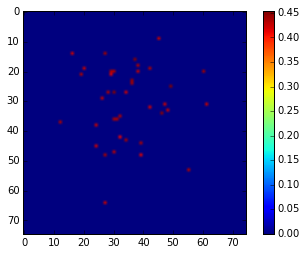

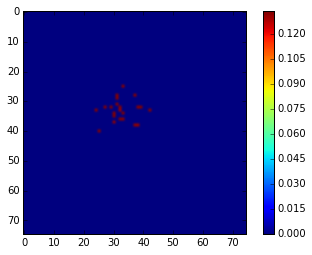

In [26]:
plt.figure()
plt.imshow(W_IE[33*N_pairs+33,:,:])
plt.colorbar()
           
plt.figure()
plt.imshow(W_II[33*N_pairs+33,:,:])
plt.colorbar()

print np.mean(W_II[33*N_pairs+33][W_II[33*N_pairs+33]!=0])
print np.mean(W_IE[33*N_pairs+33][W_IE[33*N_pairs+33]!=0])

print W_II[33*N_pairs+33][W_II[33*N_pairs+33]!=0]

print W_IE[33*N_pairs+33][W_IE[33*N_pairs+33]!=0]

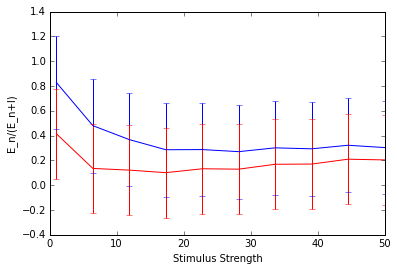

In [61]:
# Recreate figure 6C (run figure B above first)

# is this equal to the final firing rate * the appropriate weight?

E_n_input_E = np.zeros((len(c_range),len(r_units)))
I_input_E = np.copy(E_n_input_E)
E_n_input_I = np.copy(E_n_input_E)
I_input_I = np.copy(E_n_input_E)

for i in range(len(c_range)):
    for j in range(len(r_units)):
        E_n_input_E[i, j] = np.sum(results_E[i,-1,ry[j], rx[j]] * W_EE[ry[j]+N_pairs*rx[j], :, :])
        E_n_input_I[i, j] = np.sum(results_E[i,-1,ry[j], rx[j]] * W_IE[ry[j]+N_pairs*rx[j], :, :])
        I_input_E[i, j] = np.sum(results_I[i,-1,ry[j], rx[j] ] * W_EI[ry[j]+N_pairs*rx[j], :, :])
        I_input_I[i, j] = np.sum(results_I[i,-1,ry[j], rx[j] ] * W_II[ry[j]+N_pairs*rx[j], :, :])

mean_E = np.zeros(len(c_range))
mean_I = np.copy(mean_E)
sd_E = np.copy(mean_E)
sd_I = np.copy(mean_E)

for i in range(len(c_range)):
    mean_E[i] = np.mean(E_n_input_E[i,:] / ( I_input_E[i,:] + E_n_input_E[i,:] ))
    mean_I[i] = np.mean(E_n_input_I[i,:] / ( I_input_I[i,:] + E_n_input_I[i,:] ))
    sd_E = np.std(E_n_input_E[i,:] / ( I_input_E[i,:] + E_n_input_E[i,:] ))
    sd_I = np.std(E_n_input_I[i,:] / ( I_input_I[i,:] + E_n_input_I[i,:] ))

plt.figure()
plt.ylabel('E_n/(E_n+I)')
plt.xlabel('Stimulus Strength')
plt.errorbar(c_range, mean_I, sd_I)
plt.errorbar(c_range, mean_E, sd_E, fmt='r')
plt.savefig('figure6c.png')

In [20]:
print W_EE[ry[j]+N_pairs*rx[j], :, :]

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [ ]:
# Recreate figure 6D

c_range = np.linspace(1,90,10)

